<a href="https://colab.research.google.com/github/MariaBassem123/Check-in-System/blob/main/Face_Recognition_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Problem Statement**

We intend to perform face recognition. Face recognition means that for a given image
you can tell the subject id. Our database of subject is very simple. It has 40 subjects.
Below we will show the needed steps to achieve the goal of the assignment

In [ ]:
import zipfile
from google.colab import drive
import numpy as np
import os
import cv2
from scipy.linalg import eig, pinv
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA as PrincipalComponentAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
import random
from math import ceil
from IPython.display import display_markdown
from tabulate import tabulate

# 1. Download the Dataset and Understand the Format

> a. ORL dataset is available at the following
link. https://www.kaggle.com/kasikrit/att-database-of-faces/

> b. The dataset has 10 images per 40 subjects. Every image is a grayscale image of size 92x112.

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Specify the path to your ZIP file
zip_file_path = "/content/drive/MyDrive/Faces.zip"

# Specify the extraction directory
extraction_directory = "/content/Faces Database"

# Open and extract the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_file:
    zip_file.extractall(extraction_directory)

# 2. Generate the Data Matrix and the Label vector (2.5 Points)
>a. Convert every image into a vector of 10304 values corresponding to the image size.

>b. Stack the 400 vectors into a single Data Matrix D and generate the label vector y. The labels are integers from 1:40 corresponding to the subject id.

In [ ]:
def generate_data_matrix_and_label_vector(dataset_path):
    """
    Generate a data matrix and label vector from a dataset of face images.

    Parameters:
    - dataset_path (str): Path to the root directory containing subject-wise subfolders.

    Returns:
    - data_matrix (numpy.ndarray): 2D array where each row represents a flattened image.
    - label_vector (numpy.ndarray): 1D array containing labels corresponding to each image.
    """
    data = []
    labels = []

    # Iterate over subject folders
    for subject_id in range(1, 41):
        folder_name = 's' + str(subject_id)
        folder_path = os.path.join(dataset_path, folder_name)

        # Iterate over images for each subject
        for img_num in range(1, 11):
            img_name = str(img_num) + '.pgm'
            pgm_path = os.path.join(folder_path, img_name)

            # Use cv2 to read PGM file
            image = cv2.imread(pgm_path, cv2.IMREAD_GRAYSCALE)

            # Flatten the image into a 1D vector
            image_vector = image.reshape(-1)

            # Append image vector and corresponding label
            data.append(image_vector)
            labels.append(subject_id)

    # Convert lists to numpy arrays
    data_matrix = np.array(data)
    label_vector = np.array(labels)

    return data_matrix, label_vector

In [ ]:
# Specify the path to the dataset
dataset_path = "/content/Faces Database"
D, y = generate_data_matrix_and_label_vector(dataset_path)
print(D[:5, :])
print("Data matrix dimensions: ", D.shape)
print("label vector dimensions: ", y.shape[0])

[[48 49 45 ... 47 46 46]
 [60 60 62 ... 32 34 34]
 [39 44 53 ... 29 26 29]
 [63 53 35 ... 41 10 24]
 [64 76 80 ... 35 37 39]]
Data matrix dimensions:  (400, 10304)
label vector dimensions:  400


# 3. Split the Dataset into Training and Test sets (2.5 Points)

>a. From the Data Matrix D400x10304 keep the odd rows for training and the even rows for testing. This will give you 5 instances per person for training and 5 instances per person for testing.

>b. Split the labels vector accordingly

In [ ]:
def split_data_evenly(data_matrix, label_vector):
    """
    Split data into training and testing sets based on even and odd indices.

    Parameters:
    - data_matrix (numpy.ndarray): 2D array where each row represents a data point.
    - label_vector (numpy.ndarray): 1D array containing labels corresponding to each data point.

    Returns:
    - testing_data (numpy.ndarray): 2D array containing data points with even indices for testing.
    - testing_label (numpy.ndarray): 1D array containing labels corresponding to testing_data.
    - training_data (numpy.ndarray): 2D array containing data points with odd indices for training.
    - training_label (numpy.ndarray): 1D array containing labels corresponding to training_data.
    """
    testing_data = []
    training_data = []
    testing_label = []
    training_label = []

    # Iterate over data points
    for i in range(data_matrix.shape[0]):
        if i % 2 == 0:
            # Use even indices for testing
            testing_data.append(data_matrix[i])
            testing_label.append(label_vector[i])
        else:
            # Use odd indices for training
            training_data.append(data_matrix[i])
            training_label.append(label_vector[i])

    # Convert lists to numpy arrays
    testing_data = np.array(testing_data)
    testing_label = np.array(testing_label)
    training_data = np.array(training_data)
    training_label = np.array(training_label)

    return testing_data, testing_label, training_data, training_label


In [ ]:
test_data, test_label, train_data, train_label = split_data_evenly(D, y)
print("test_data")
print(test_data[:5,:])
print(f"test_label.shape = {test_label.shape}")
print("train_data")
print(train_data[:5,:])

test_data
[[48 49 45 ... 47 46 46]
 [39 44 53 ... 29 26 29]
 [64 76 80 ... 35 37 39]
 [41 47 47 ... 35 37 38]
 [42 41 44 ... 42 43 41]]
test_label.shape = (200,)
train_data
[[ 60  60  62 ...  32  34  34]
 [ 63  53  35 ...  41  10  24]
 [ 43  50  41 ... 158 153 169]
 [ 44  43  32 ...  43  43  37]
 [ 34  34  33 ...  37  40  33]]


#4. Classification using PCA (30 points)
>a. Use the pseudo code below for computing the projection matrix U.
Define the alpha = {0.8, 0.85, 0.9, 0.95}

>b. Project the training set, and test sets separately using the same projection matrix.

>c. Use a simple classifier (first Nearest Neighbor to determine the class labels).

>d. Report Accuracy for every value of alpha separately.

>e. Can you find a relation between alpha and classification accuracy?


In [ ]:
def PCA(data: np.ndarray, alpha: float,*alphas: float):
  """
  perform PCA on the given data

  Parameters
  ----------
  data : np.ndarray
      the data on which the PCA will be performed.
  alpha : float
      used to determine dimensionality.

  Returns
  -------
  the projection matrix or a list of the projection matrices in case
  more than one alpha was specified.
  """
  covariance_matrix = np.cov(data, rowvar=False)
  eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

  sort_order = np.argsort(eigenvalues)[::-1]
  eigenvalues = eigenvalues[sort_order]
  eigenvectors = eigenvectors[:, sort_order]

  fraction_of_total_variance = np.cumsum(eigenvalues) / sum(eigenvalues)

  projection_matrices = []
  r = np.argmax(fraction_of_total_variance >= alpha)
  projection_matrices.append(eigenvectors[:,:r + 1])

  if not alphas:
    return projection_matrices[0]

  for a in alphas:
    r = np.argmax(fraction_of_total_variance >= a)
    projection_matrices.append(eigenvectors[:,:r + 1])
  return projection_matrices

In [ ]:
def draw_eigenfaces(projection_matrix: np.ndarray,
                    transpose: bool = True,
                    ncols: int = 10):

  if transpose:
    projection_matrix = projection_matrix.transpose()

  n = len(projection_matrix)
  nrows= ceil(n / ncols)
  figure, axs = plt.subplots(nrows, ncols, figsize=(2*ncols, 2*nrows))
  axs = axs.flatten()

  for ax in axs:
    ax.axis('off')

  for i in range(n):
    axs[i].imshow(projection_matrix[i].reshape((112, 92)),
                  cmap='gray',
                  aspect='equal')
    axs[i].set_title(f'eigenface {i}')

  plt.show()

In [ ]:
def project(data, U):
  return np.dot(U, data.T).T

In [ ]:
def get_accuarcy(projection_matrix: np.ndarray,
                 train_data: np.ndarray,
                 train_label: np.ndarray,
                 test_data: np.ndarray,
                 test_label: np.ndarray,
                 transpose: bool = True,
                 center: bool = True,
                 n_of_neighbors: int = 1):

  if transpose:
    projection_matrix = projection_matrix.transpose()

  if center:
    mean = np.mean(train_data,axis = 0)
    projected_train = project(train_data - mean, projection_matrix)
    projected_test = project(test_data - mean, projection_matrix)
  else:
    projected_train = project(train_data, projection_matrix)
    projected_test = project(test_data, projection_matrix)

  knn_classifier = KNeighborsClassifier(n_neighbors = n_of_neighbors)
  knn_classifier.fit(projected_train, train_label)
  pred = knn_classifier.predict(projected_test)

  return accuracy_score(test_label, pred), pred

In [ ]:
alphas = [0.8, 0.85, 0.9, 0.95]
projection_matrices = PCA(train_data,*alphas)

In [ ]:
accuarcy_PCA_table = []
for projection_matrix, alpha in zip(projection_matrices, alphas):
  accuarcy,_ = get_accuarcy(projection_matrix,
                          train_data,
                          train_label,
                          test_data,
                          test_label)
  accuarcy_PCA_table.append([alpha,accuarcy])
display_markdown(
    "## The accuracy for every value of alpha\n"+
    tabulate(accuarcy_PCA_table, ["alpha", "accuarcy"], tablefmt="html"),
    raw=True
    )

## The accuracy for every value of alpha
<table>
<thead>
<tr><th style="text-align: right;">  alpha</th><th style="text-align: right;">  accuarcy</th></tr>
</thead>
<tbody>
<tr><td style="text-align: right;">   0.8 </td><td style="text-align: right;">     0.93 </td></tr>
<tr><td style="text-align: right;">   0.85</td><td style="text-align: right;">     0.94 </td></tr>
<tr><td style="text-align: right;">   0.9 </td><td style="text-align: right;">     0.945</td></tr>
<tr><td style="text-align: right;">   0.95</td><td style="text-align: right;">     0.935</td></tr>
</tbody>
</table>

# Relation between alpha and classification accuracy:
As the alpha value increases, the classification accuracy tends to increase.

However, the decrese that happened for alpha = 0.95 may be due to several factors:

1.   Over-regularization problem. A higher alpha value may introduce stronger regularization, which can be beneficial up to a certain point. However, if the regularization becomes too strong, it may cause the model to underfit the data, leading to a decrease in accuracy.
2.   Also, another valid explanation is that it is possible that the highest accuracy is achieved at a slightly lower alpha than 0.95 as alpha is a hyperparameter that is determined by trial.

## The eigenfaces for PCA (alpha = 0.95)

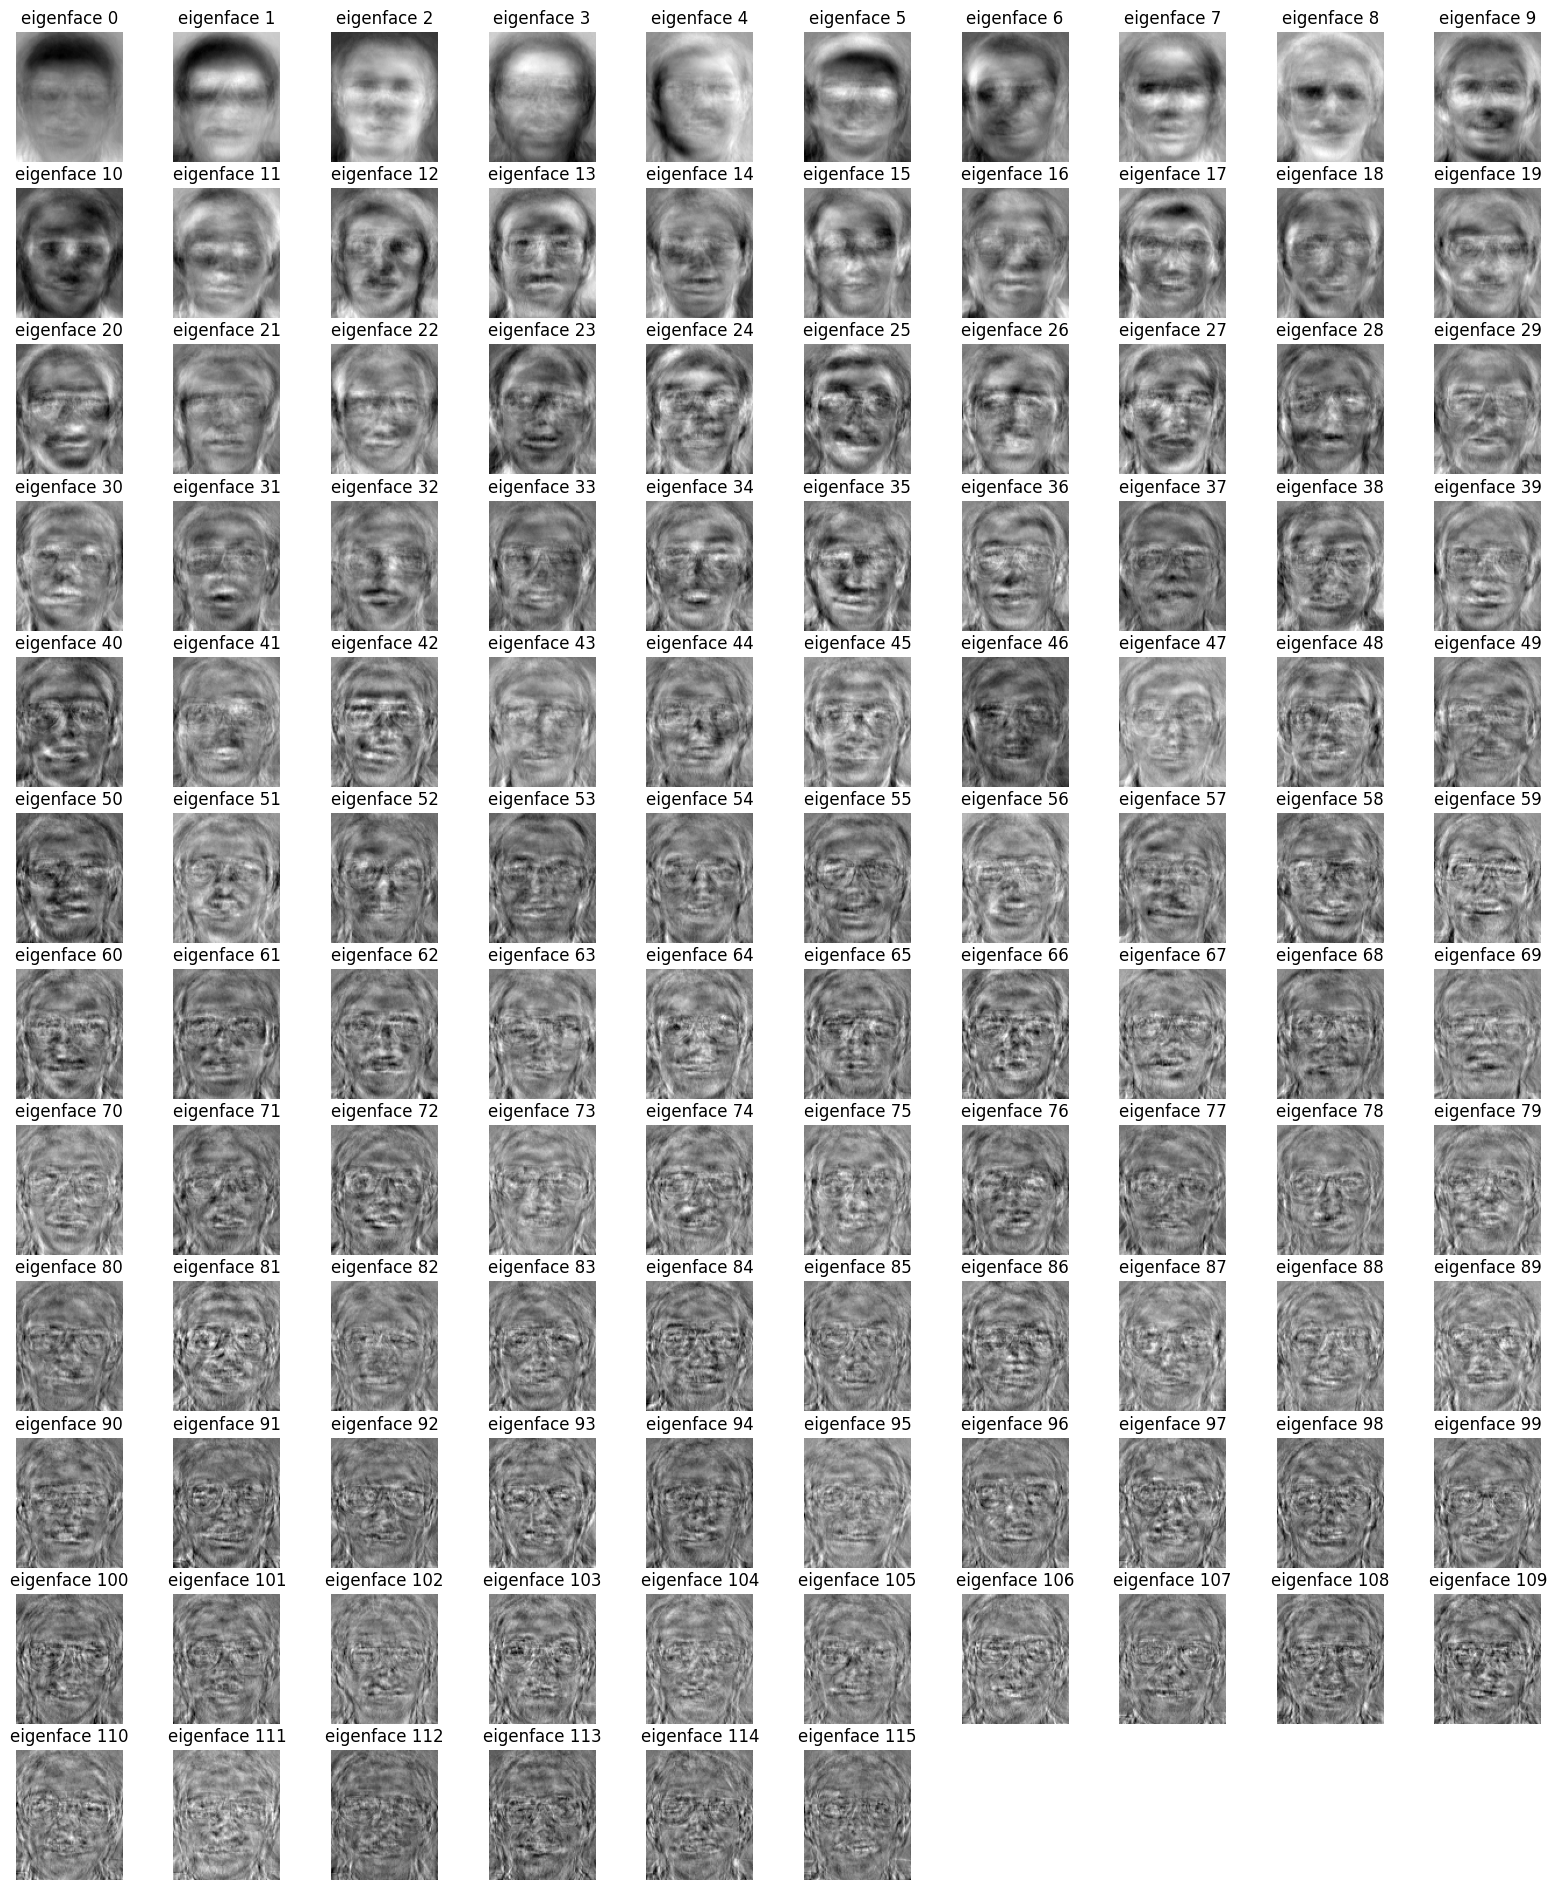

In [ ]:
display_markdown("## The eigenfaces for PCA (alpha = 0.95)", raw=True)
draw_eigenfaces(projection_matrices[3])

#5. Classification Using LDA (30 Points)

>a. Use the pseudo code below for LDA. We will modify few lines in
pseudocode to handle multiclass LDA.

>>i. Calculate the mean vector for every class Mu1, Mu2, ..., Mu40.

>>ii. Replace B matrix by Sb.
Sb = ∑nk (μk − μ)(μk − μ)T.
Here, m is the number of classes, μ is the overall sample mean, and nk is the
number of samples in the k-th class.

>>iii. S matrix remains the same, but it sums S1, S2, S3, ...S40.
>>iv. Use 39 dominant eigenvectors instead of just one. You will
have a projection matrix U39x10304.

>b. Project the training set, and test sets separately using the same
projection matrix U. You will have 39 dimensions in the new space.

>c. Use a simple classifier (first Nearest Neighbor to determine the class
labels).

>d. Report accuracy for the multiclass LDA on the face recognition
dataset.

>e. Compare the results to PCA results.

In [ ]:
def split_by_label_LDA(D, y):
    """
    Split a dataset into sublists based on labels for Linear Discriminant Analysis (LDA).

    Parameters:
    - D (numpy.ndarray): 2D array where each row represents a data point.
    - y (numpy.ndarray): 1D array containing labels corresponding to each data point.

    Returns:
    data_by_label (list): A list of sublists, where each sublist contains data points with the same label.
    """
    data_by_label = [[] for _ in range(max(y))]

    # Iterate through the samples in the dataset
    for i in range(y.shape[0]):
        # Append the i-th sample to the sublist corresponding to its label
        data_by_label[y[i] - 1].append(D[i])

    # Return the list of sublists, where each sublist contains data points with the same label
    return data_by_label


In [ ]:
def calculate_class_mean(data_by_label):
    """
    Calculate the mean vectors for each class in a dataset.

    Parameters:
    - data_by_label (list): A list of sublists, where each sublist contains data points with the same label.

    Returns:
    means_vectors (numpy.ndarray): A 2D array where each row represents the mean vector for a class.
    """
    means_vectors = []

    # Iterate through sublists (classes) in the dataset
    for class_data in data_by_label:
        class_data_array = np.array(class_data)

        # Calculate the mean vector for the current class
        class_mean = np.mean(class_data_array, axis=0)
        means_vectors.append(class_mean)

    # Convert the list of mean vectors to a numpy array
    means_vectors = np.array(means_vectors)

    return means_vectors


In [ ]:
def calculate_between_class_scatter_matrix(means_vectors,
                                           overall_sample_mean,
                                           nk):
    """
    Calculate the between-class scatter matrix

    Parameters:
    - means_vectors (numpy.ndarray): 2D array where each row represents the mean vector for a class.
    - overall_sample_mean (numpy.ndarray): 1D array representing the overall mean vector of the entire dataset.
    - nk (list): List containing the number of samples in each class.

    Returns:
    sb (numpy.ndarray): 2D array representing the between-class scatter matrix.
    """
    sb = np.zeros((means_vectors.shape[1], means_vectors.shape[1]))

    # Iterate through mean vectors for each class
    for i in range(means_vectors.shape[0]):
        mean_diff = means_vectors[i] - overall_sample_mean

        # Update the between-class scatter matrix using the mean difference and sample count
        sb += nk[i] * np.outer(mean_diff, mean_diff)

    return sb


In [ ]:
def center_data(data_by_label, means_vectors):
    """
    Center the data by subtracting class mean vectors from each class.

    Parameters:
    - data_by_label (list): A list of sublists, where each sublist contains data points with the same label.
    - means_vectors (numpy.ndarray): 2D array where each row represents the mean vector for a class.

    Returns:
    Z (list): A list of 2D arrays, where each array represents the centered data points for a class.
    """
    Z = [[] for _ in range(len(data_by_label))]

    # Iterate through sublists (classes) in the dataset
    for i in range(len(data_by_label)):
        # Center the data by subtracting the mean vector of the current class
        Z[i] = (data_by_label[i] - means_vectors[i])

    return Z


In [ ]:
def calculate_class_scatter_matrix(Z):
    """
    Calculate the class scatter matrix for Linear Discriminant Analysis (LDA).

    Parameters:
    - Z (list): A list of 2D arrays, where each array represents the data points in a projected subspace.

    Returns:
    S (numpy.ndarray): 2D array representing the class scatter matrix.
    """
    S = np.zeros((Z[0].shape[1], Z[0].shape[1]))

    # Iterate through the projected subspaces
    for i in range(len(Z)):
        temp = np.array(Z[i])

        # Update the class scatter matrix using the dot product of the transpose and the array
        S += np.dot(np.transpose(temp), temp)

    return S


In [ ]:
def compute_eigen_vectors(S, sb):
    """
    Compute the eigenvalues and eigenvectors for Linear Discriminant Analysis (LDA).

    Parameters:
    - S (numpy.ndarray): 2D array representing the class scatter matrix.
    - sb (numpy.ndarray): 2D array representing the between-class scatter matrix.

    Returns:
    eigenvalues (numpy.ndarray): eigenvalues
    eigenvectors (numpy.ndarray): eigenvectors
    """
    eigenvalues, eigenvectors = eig(np.dot(pinv(S), sb))
    return eigenvalues, eigenvectors


In [ ]:
def LDA_helper(D, y):
    """
    Helper function for (LDA) computations for RAM purposes.

    Parameters:
    - D (numpy.ndarray): 2D array where each row represents a data point.
    - y (numpy.ndarray): 1D array containing labels corresponding to each data point.

    Returns:
    Tuple[numpy.ndarray, numpy.ndarray]: A tuple containing class scatter matrix (S), between-class scatter matrix (sb).
    """
    # Split data by label
    data_by_label = split_by_label_LDA(D, y)

    # Calculate mean vectors for each class
    means_vectors = calculate_class_mean(data_by_label)

    # Calculate the overall sample mean
    overall_sample_mean = np.mean(means_vectors, axis=0)

    # Center the data
    Z = center_data(data_by_label, means_vectors)

    # Compute sample counts per class
    nk = [len(class_data) for class_data in data_by_label]

    # Calculate between-class scatter matrix
    sb = calculate_between_class_scatter_matrix(means_vectors,
                                                overall_sample_mean,
                                                nk)

    # Calculate class scatter matrix
    S = calculate_class_scatter_matrix(Z)

    return S, sb

def LDA(S, sb, n):
    """
    Perform Linear Discriminant Analysis (LDA) and return the transformation matrix U.

    Parameters:
    - S (numpy.ndarray): Within-class scatter matrix.
    - sb (numpy.ndarray): Between-class scatter matrix.
    - n (int): Number of dominant eigenvectors to retain.

    Returns:
    U (numpy.ndarray): Transformation matrix U with the shape (original_feature_dim, n).
    """
    eigenvalues, eigenvectors = compute_eigen_vectors(S, sb)

    # Sort eigenvalues and eigenvectors
    sort_order = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sort_order]
    eigenvectors = eigenvectors[:, sort_order]

    # Select the first n eigenvectors
    U_transpose = eigenvectors[:, :n]
    U = U_transpose.T

    return U


In [ ]:
S, sb= LDA_helper(train_data,train_label)
U_lda = LDA(S, sb, 39)
U_lda= np.real(U_lda)

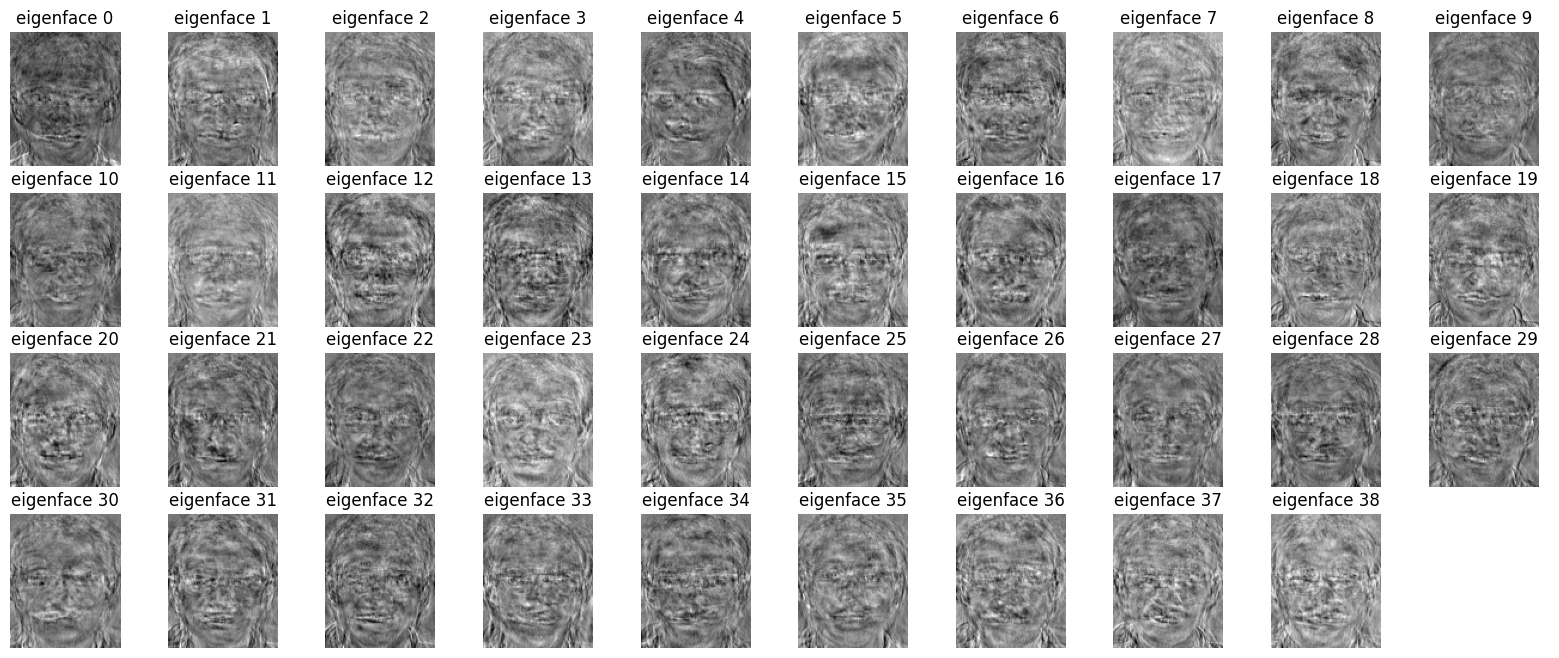

In [ ]:
draw_eigenfaces(U_lda, False)

In [ ]:
lda_accuracy,_ = get_accuarcy(U_lda,
                              train_data,
                              train_label,
                              test_data,
                              test_label,
                              False,
                              False)
print(f"LDA accuracy: {lda_accuracy:.3f}")

# display_markdown(
#     "## The accuracy of the implemented PCA for every value of alpha\n"+
#     tabulate(accuarcy_PCA_table, ["alpha", "accuarcy"], tablefmt="html"),
#     raw=True
#     )

LDA accuracy: 0.960


# *Comparison between  the results of LDA to that of PCA:*

- LDA achieved an accuracy of 0.960.
- PCA with different alpha values achieved accuracies ranging from 0.93 to 0.945.

<u><b>Observations:</b></u>

- As observed LDA beated PCA in terms of accuracy in this comparison at k = 1.

- The choice of alpha in PCA influenced the accuracy, and the highest PCA accuracy (0.945) is still slightly lower than the LDA accuracy.

- LDA was effective here on our data set as there are distinct class separations, because the objective of LDA was to maximize the differences between classes and minimize the differences within the same class.
However, PCA's objective was to capture overall variance in the data and not to make class separation.


# 6. Classifier Tuning (20 Points)
> a. Set the number of neighbors in the K-NN classifier to 1, 3, 5, 7.

> b. Tie breaking at your preferred strategy.

> c. Plot (or tabulate) the performance measure (accuracy) against the
K value. This is to be done for PCA and LDA as well.




In [ ]:
k_values = [1, 3, 5, 7]

# PCA classifier tuning
## Accuarcy at different k and alpha

<table>
<thead>
<tr><th style="text-align: right;">  k value</th><th style="text-align: right;">  alpha = 0.8</th><th style="text-align: right;">  alpha = 0.85</th><th style="text-align: right;">  alpha = 0.9</th><th style="text-align: right;">  alpha = 0.95</th></tr>
</thead>
<tbody>
<tr><td style="text-align: right;">        1</td><td style="text-align: right;">        0.93 </td><td style="text-align: right;">         0.94 </td><td style="text-align: right;">        0.945</td><td style="text-align: right;">         0.935</td></tr>
<tr><td style="text-align: right;">        3</td><td style="text-align: right;">        0.855</td><td style="text-align: right;">         0.855</td><td style="text-align: right;">        0.85 </td><td style="text-align: right;">         0.845</td></tr>
<tr><td style="text-align: right;">        5</td><td style="text-align: right;">        0.805</td><td style="text-align: right;">         0.83 </td><td style="text-align: right;">        0.815</td><td style="text-align: right;">         0.815</td></tr>
<tr><td style="text-align: right;">        7</td><td style="text-align: right;">        0.78 </td><td style="text-align: right;">         0.775</td><td style="text-align: right;">        0.755</td><td style="text-align: right;">         0.74 </td></tr>
</tbody>
</table>

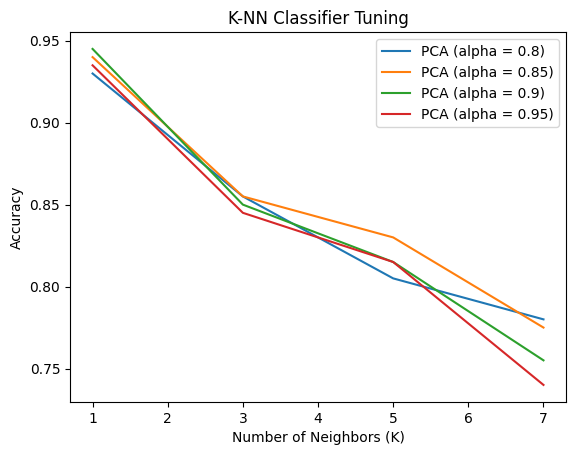

In [ ]:
display_markdown(
    "# PCA classifier tuning\n## Accuarcy at different k and alpha",
    raw=True
    )
accuracy_pca = []
k_values_PCA_table = {}
n = len(alphas)

k_values_PCA_table["k value"] = k_values

for i in range(n):
  for k in k_values:
    accuracy_pca.append([])
    acc_pca,_ = get_accuarcy(projection_matrices[i],
                            train_data,
                            train_label,
                            test_data,
                            test_label,
                            n_of_neighbors = k)
    accuracy_pca[i].append(acc_pca)
  k_values_PCA_table[f"alpha = {alphas[i]}"] = accuracy_pca[i]

# table
display_markdown(tabulate(k_values_PCA_table, headers="keys", tablefmt="html"),
                 raw=True)

# plot
for i in range(n):
  plt.plot(k_values, accuracy_pca[i], label=f'PCA (alpha = {alphas[i]})')

plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Accuracy')
plt.title('K-NN Classifier Tuning')
plt.legend()
plt.show()

As K increases noise from unrelated points is introduced as our traning data set is small.

# LDA classifier tuning
## Accuarcy at different k

<table>
<thead>
<tr><th style="text-align: right;">  k value</th><th style="text-align: right;">  accuarcy</th></tr>
</thead>
<tbody>
<tr><td style="text-align: right;">        1</td><td style="text-align: right;">     0.96 </td></tr>
<tr><td style="text-align: right;">        3</td><td style="text-align: right;">     0.885</td></tr>
<tr><td style="text-align: right;">        5</td><td style="text-align: right;">     0.905</td></tr>
<tr><td style="text-align: right;">        7</td><td style="text-align: right;">     0.92 </td></tr>
</tbody>
</table>

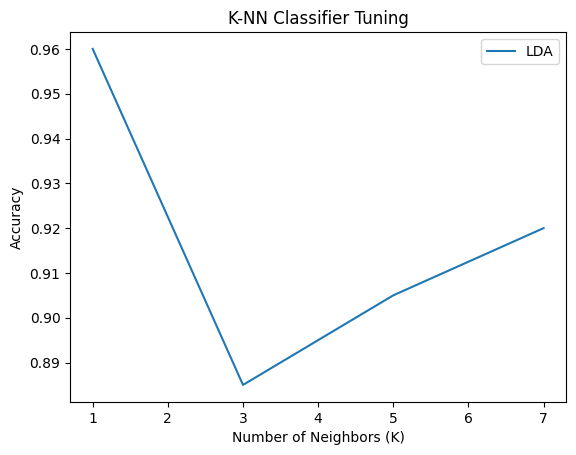

In [ ]:
display_markdown(
    "# LDA classifier tuning\n## Accuarcy at different k",
    raw=True
    )

accuracy_lda = []
k_values_LDA_table = []

for k in k_values:
  acc_lda,_ = get_accuarcy(U_lda,
                           train_data,
                           train_label,
                           test_data,
                           test_label,
                           False,
                           False,
                           k)
  k_values_LDA_table.append([k, acc_lda])
  accuracy_lda.append(acc_lda)

display_markdown(
    tabulate(k_values_LDA_table, ["k value", "accuarcy"], tablefmt="html"),
    raw=True
    )
plt.plot(k_values, accuracy_lda, label='LDA')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Accuracy')
plt.title('K-NN Classifier Tuning')
plt.legend()
plt.show()

# 7. Compare vs Non-Face Images

a. Download non-face images and make them of the same size 92x112.
and try to solve the classification problem faces vs. non-faces.


> i. Show failure and success cases.

>ii. How many dominant eigenvectors will you use for the LDA solution?

> iii. Plot the accuracy vs the number of non-faces images while fixing
the number of face images.

> iv. Criticize the accuracy measure for large numbers of non-faces
images in the training data.





In [ ]:
# Specify the path to your ZIP file
zip_file_path = "/content/drive/MyDrive/Non-Faces.zip"
# Specify the extraction directory
extraction_directory = "/content/Non-Faces Database"

# Open and extract the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_file:
    zip_file.extractall(extraction_directory)

In [ ]:
def generate_nonFaces_data_matrix(dataset_path):
    """
    Generate a data matrix for non-face images from a given dataset path.

    Parameters:
    - dataset_path (str): Path to the directory containing non-face images.

    Returns:
    data_matrix (numpy.ndarray): 2D array where each row represents a flattened non-face image.
    """
    data = []

    # Iterate through non-face images
    for subject_id in range(1, 401):
        img_name = f'({subject_id}).pgm'
        img_path = os.path.join(dataset_path, img_name)

        # Use cv2 to read non-face image
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # Flatten the image to create a 1D vector
        image_vector = image.reshape(-1)
        data.append(image_vector)

    data_matrix = np.array(data)

    return data_matrix

In [ ]:
# Specify the path to the dataset
dataset_path = "/content/Non-Faces Database"
NonFaces = generate_nonFaces_data_matrix(dataset_path)
print(NonFaces[:5, :])
print(NonFaces.shape)

[[232 242 228 ... 116 117 118]
 [249 249 243 ... 190 190 189]
 [145 142 143 ...  87  94  99]
 [194 195 193 ...  67  72  79]
 [211 202 202 ... 197 197 198]]
(400, 10304)


In [ ]:
def check_success_failure(prediction, true_labels):
    """
    Check the success and failure of a classification prediction.

    Parameters:
    - prediction (numpy.ndarray): 1D array containing predicted labels.
    - true_labels (numpy.ndarray): 1D array containing true labels.

    Returns:
    success (numpy.ndarray): an array containing indices of success.
    fail (numpy.ndarray): an array containing indices of failure.
    """
    success = np.where(prediction == true_labels)[0]
    fail = np.where(prediction != true_labels)[0]
    return success, fail


In [ ]:
def calculate_accuracy_pca(D, NonFaces):
    """
    Calculate the accuracy of PCA-based KNN classification for varying numbers of non-face images.

    Parameters:
    - D (numpy.ndarray): 2D array representing the face images data.
    - NonFaces (numpy.ndarray): 2D array representing the non-face images data.

    Returns:
    n_non_faces_list(list): lists of non-face counts.
    accuracies(list): accuracies corresponding lists of non-face counts.
    """
    accuracies = []
    n_non_faces_list = []

    # Data Preparation
    test_data_with_non_faces = D[-200:, :] # Combining the last 200 rows of D and NonFaces for testing
    test_data_with_non_faces = np.append(test_data_with_non_faces,
                                         NonFaces[-100:, :], axis=0)
    test_label_with_non_faces = np.repeat([1, 2], [200, 100])

    for i in range(50, 301, 50):

        D_current = D[:200, :] #  Combining the first 200 rows of D and the first i rows of NonFaces for training
        D_current = np.append(D_current, NonFaces[:i, :], axis=0)
        y_current = np.repeat([1, 2], [200, i])

        # PCA Feature Reduction
        alpha = 0.9
        projection_matrix = PCA(D_current,alpha)
        accuarcy,y_pred = get_accuarcy(projection_matrix,
                          D_current,
                          y_current,
                          test_data_with_non_faces,
                          test_label_with_non_faces)
        print(f"At non-faces = {i}, accuracy : {accuarcy:.3f}")

        # Check success and failure instances
        success, fail = check_success_failure(y_pred, test_label_with_non_faces)
        total_success_entries = len(success)
        total_fail_entries = len(fail)
        print(f"Number of successful checks: {total_success_entries}/{len(test_label_with_non_faces)}")
        print(f"Number of failed checks: {total_fail_entries}/{len(test_label_with_non_faces)}")
        accuracies.append(accuarcy)
        n_non_faces_list.append(i)
        # plot D_current[success[0]], D_current[fail[0]]

        plt.subplot(1, 2, 1)
        plt.imshow(test_data_with_non_faces[success[random.randint(0, success.shape[0] - 1)]].reshape((112, 92)), cmap='gray')
        plt.title('Success')

        plt.subplot(1, 2, 2)
        plt.imshow(test_data_with_non_faces[fail[random.randint(0, fail.shape[0] - 1)]].reshape((112, 92)), cmap='gray')
        plt.title('Failure')
        plt.show()

    return n_non_faces_list, accuracies

At non-faces = 50, accuracy : 0.993
(298,)
Number of successful checks: 298/300
Number of failed checks: 2/300


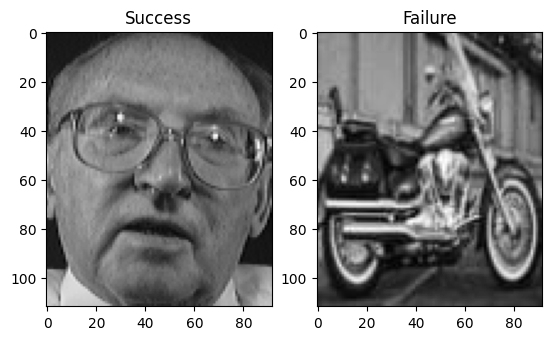

At non-faces = 100, accuracy : 0.983
(295,)
Number of successful checks: 295/300
Number of failed checks: 5/300


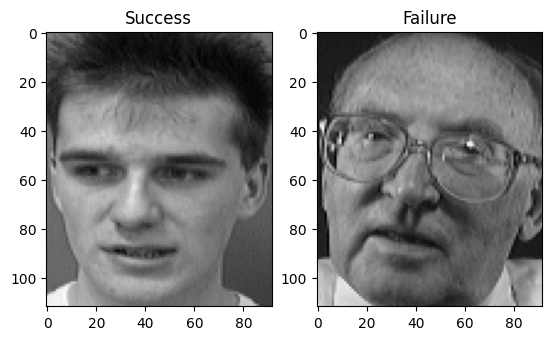

At non-faces = 150, accuracy : 0.987
(296,)
Number of successful checks: 296/300
Number of failed checks: 4/300


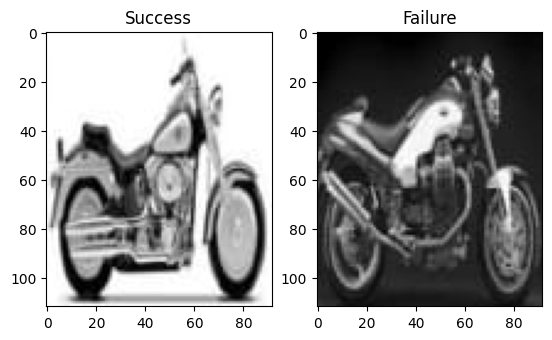

At non-faces = 200, accuracy : 0.937
(281,)
Number of successful checks: 281/300
Number of failed checks: 19/300


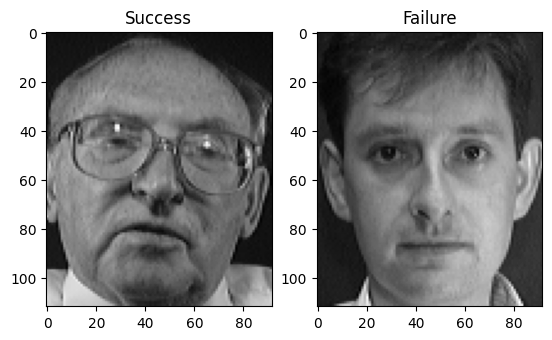

At non-faces = 250, accuracy : 0.883
(265,)
Number of successful checks: 265/300
Number of failed checks: 35/300


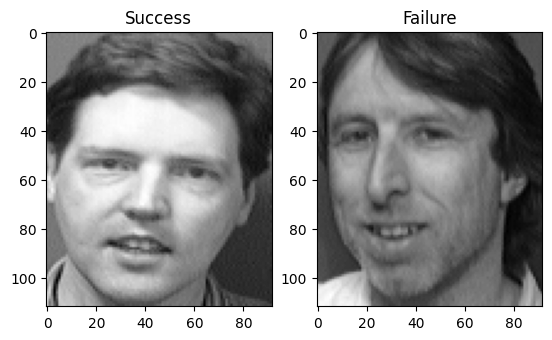

At non-faces = 300, accuracy : 0.877
(263,)
Number of successful checks: 263/300
Number of failed checks: 37/300


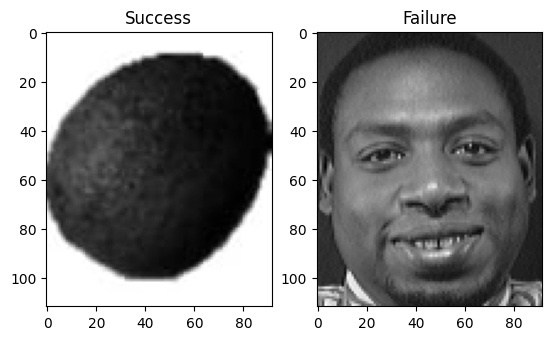

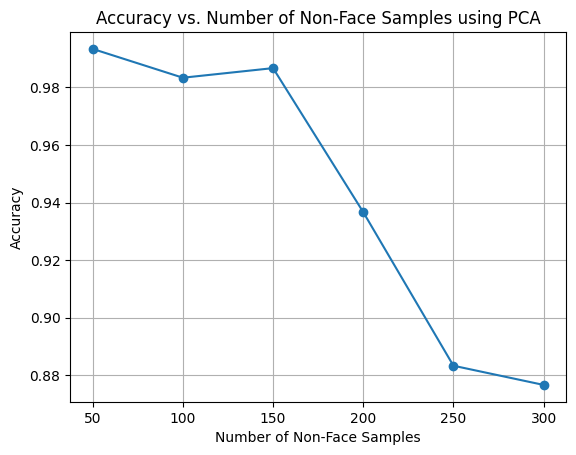

In [ ]:
n_non_faces_list, pca_accuracies = calculate_accuracy_pca(D, NonFaces)
plt.plot(n_non_faces_list, pca_accuracies, marker='o')
plt.xlabel('Number of Non-Face Samples')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Non-Face Samples using PCA')
plt.grid(True)
plt.show()

At non-faces = 50, accuracy : 0.977
Number of successful checks: 293/300
Number of failed checks: 7/300


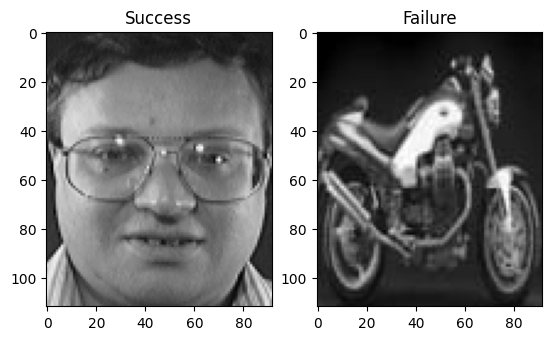

At non-faces = 100, accuracy : 0.977
Number of successful checks: 293/300
Number of failed checks: 7/300


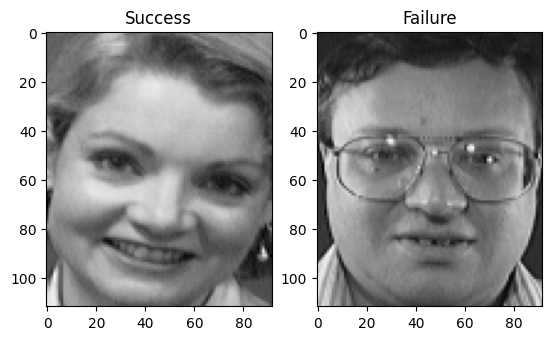

At non-faces = 150, accuracy : 0.903
Number of successful checks: 271/300
Number of failed checks: 29/300


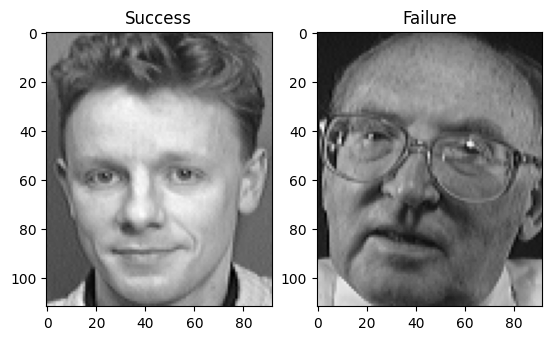

At non-faces = 200, accuracy : 0.847
Number of successful checks: 254/300
Number of failed checks: 46/300


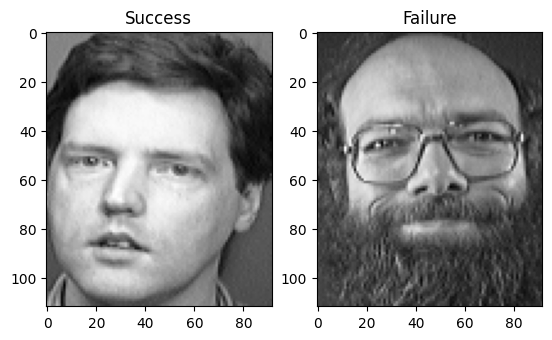

At non-faces = 250, accuracy : 0.817
Number of successful checks: 245/300
Number of failed checks: 55/300


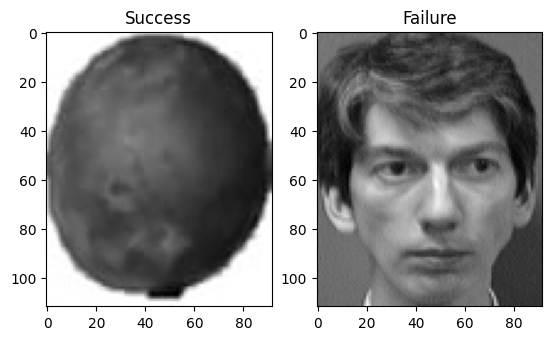

At non-faces = 300, accuracy : 0.777
Number of successful checks: 233/300
Number of failed checks: 67/300


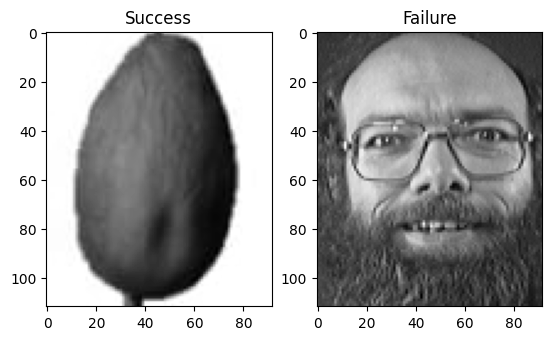

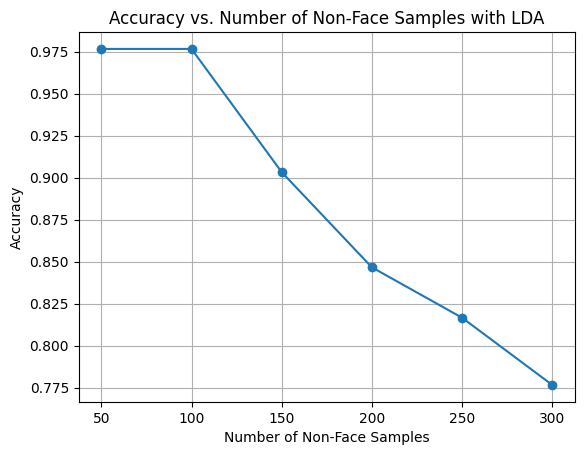

In [ ]:
def calculate_accuracy_lda(D, NonFaces):
    """
    Calculate the accuracy of LDA-based KNN classification for varying numbers of non-face images.

    Parameters:
    - D (numpy.ndarray): 2D array representing the face images data.
    - NonFaces (numpy.ndarray): 2D array representing the non-face images data.

    Returns:
    n_non_faces_list(list): lists of non-face counts.
    accuracies(list): accuracies corresponding lists of non-face counts.
    """
    accuracies = []
    n_non_faces_list = []

    # Data Preparation
    test_data_with_non_faces = D[-200:, :]  # Combining the last 200 rows of D and NonFaces for testing
    test_data_with_non_faces = np.append(test_data_with_non_faces, NonFaces[-100:, :], axis=0)
    test_label_with_non_faces = np.repeat([1, 2], [200, 100])

    for i in range(50, 301, 50):

        D_current = D[:200, :]  # Combining the first 200 rows of D and the first i rows of NonFaces for training
        D_current = np.append(D_current, NonFaces[:i, :], axis=0)
        y_current = np.repeat([1, 2], [200, i])

        # LDA Feature Reduction
        S, sb = LDA_helper(D_current, y_current)
        U = LDA(S, sb, 1)  # use 1 because the number of dominant eigenvectors will be equal to the number of classes - 1 = 2-1
        U = np.real(U)

        accuracy, y_pred = get_accuarcy(U,
                 D_current,
                 y_current,
                 test_data_with_non_faces,
                 test_label_with_non_faces,
                 False,
                 False)
        print(f"At non-faces = {i}, accuracy : {accuracy:.3f}")

        # Check success and failure instances
        success, fail = check_success_failure(y_pred, test_label_with_non_faces)
        total_success_entries = len(success)
        total_fail_entries = len(fail)
        print(f"Number of successful checks: {total_success_entries}/{len(test_label_with_non_faces)}")
        print(f"Number of failed checks: {total_fail_entries}/{len(test_label_with_non_faces)}")
        accuracies.append(accuracy)
        n_non_faces_list.append(i)

        # Plot success and failure instances
        plt.subplot(1, 2, 1)
        plt.imshow(test_data_with_non_faces[success[random.randint(0, total_success_entries - 1)]].reshape((112, 92)), cmap='gray')
        plt.title('Success')

        plt.subplot(1, 2, 2)
        plt.imshow(test_data_with_non_faces[fail[random.randint(0, total_fail_entries - 1)]].reshape((112, 92)), cmap='gray')
        plt.title('Failure')
        plt.show()

    return n_non_faces_list, accuracies

n_non_faces_list, lda_accuracies = calculate_accuracy_lda(D, NonFaces)

plt.plot(n_non_faces_list, lda_accuracies, marker='o')
plt.xlabel('Number of Non-Face Samples')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Non-Face Samples with LDA')
plt.grid(True)
plt.show()

# *Number of dominant eigenvectors:*
- In practice, the number of dominant eigenvectors are chosen to be equal to the number of classes minus one. In our case, where we have two classes (face and non-face), this implies selecting 1 dominant eigenvector.

- This choice fits our classification problem and is consistent with the typical practice.

# *Criticizing accuracy measure for large numbers of non-faces images:*

With an increase in the number of non-face images in the training data from 50 to 300, the distribution of classes becomes more imbalanced.

Imbalanced datasets can lead to biased models, as the classifier may become more specialized in recognizing the majority class and may not perform as well on the minority class.

# 8. Bonus (15 Points)
>a. [5 points] Use different Training and Test splits. Change the number of
instances per subject to be 7 and keep 3 instances per subject for testing.
compare the results you have with the ones you got earlier with 50%
split.

In [ ]:
def split_data_70_30(data_matrix, label_vector):
  """
  Split data into training and testing sets using a 70-30 ratio..

  Parameters:
  - data_matrix (numpy.ndarray): 2D array where each row represents a data point.
  - label_vector (numpy.ndarray): 1D array containing labels corresponding to each data point.

  Returns:
  - testing_data (numpy.ndarray): 2D array containing data points testing.
  - testing_label (numpy.ndarray): 1D array containing labels corresponding to testing_data.
  - training_data (numpy.ndarray): 2D array containing data points training.
  - training_label (numpy.ndarray): 1D array containing labels corresponding to training_data.
  """
  testing_data = []
  training_data = []

  testing_label = []
  training_label = []

  for i in range (data_matrix.shape[0]):
    if i % 10 in range(0, 7):
      training_data.append(data_matrix[i])
      training_label.append(label_vector[i])
    else:
      testing_data.append(data_matrix[i])
      testing_label.append(label_vector[i])

  return np.array(testing_data), np.array(testing_label), np.array(training_data), np.array(training_label)

In [ ]:
test30_data, test30_label, train70_data, train70_label = split_data_70_30(D,y)
print("test30_data")
print(test30_data.shape)
print("train70_data")
print(train70_data.shape)

test30_data
(120, 10304)
train70_data
(280, 10304)


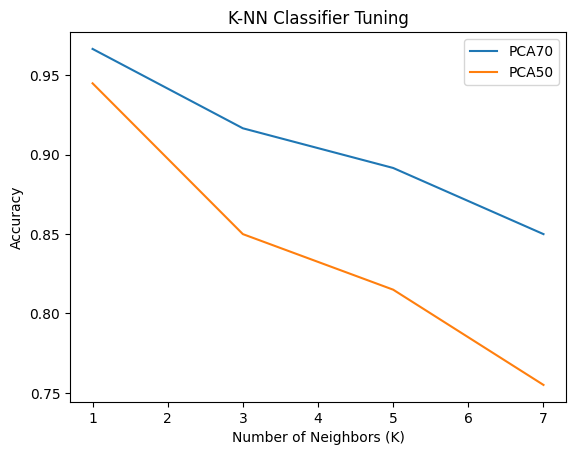

In [ ]:
#pca
k_values = [1, 3, 5, 7]

accuracy70_pca = []

alpha =  0.9
projection_matrix70 = PCA(train70_data,alpha)

for k in k_values:
  acc70,_= get_accuarcy(projection_matrix70,
                        train70_data,
                        train70_label,
                        test30_data,
                        test30_label,
                        n_of_neighbors = k)
  accuracy70_pca.append(acc70)


plt.plot(k_values, accuracy70_pca, label='PCA70')
plt.plot(k_values, accuracy_pca[2], label='PCA50')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Accuracy')
plt.title('K-NN Classifier Tuning')
plt.legend()
plt.show()

In [ ]:
S70, sb70= LDA_helper(train70_data, train70_label)
U70 = LDA(S70, sb70, 39)
U70 = np.real(U70)

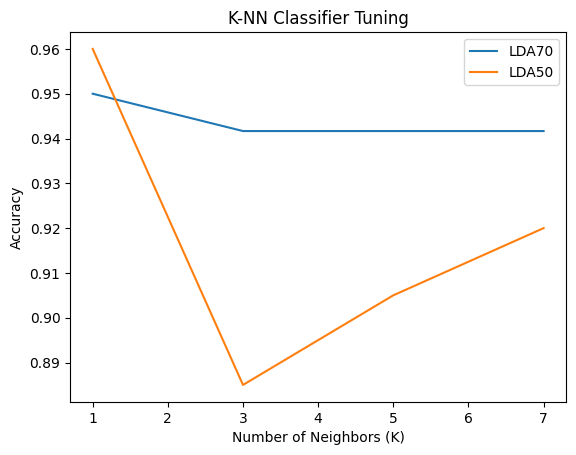

In [ ]:
k_values = [1, 3, 5, 7]

accuracy70_lda = []
accuracy_lda = []


for k in k_values:
  # knn_lda70 = KNeighborsClassifier(n_neighbors=k)
  # knn_lda70.fit(projected_train70_lda, train70_label)
  # predictions30_lda = knn_lda70.predict(projected_test30_lda)
  acc70,_= get_accuarcy(U70,
                        train70_data,
                        train70_label,
                        test30_data,
                        test30_label,
                        False,
                        False,
                        k)
  accuracy70_lda.append(acc70)

  acc,_= get_accuarcy(U_lda,
                      train_data,
                      train_label,
                      test_data,
                      test_label,
                      False,
                      False,
                      k)
  accuracy_lda.append(acc)

plt.plot(k_values, accuracy70_lda, label='LDA70')
plt.plot(k_values, accuracy_lda, label='LDA50')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Accuracy')
plt.title('K-NN Classifier Tuning')
plt.legend()
plt.show()

# *Effect of Training-Test Split Variation:*
- We compared the results obtained at the 50-50 split and that obtained at the 70-30 split

- It was noticed that increasing the training data from 50% to 70% has resulted in higher accuracy for LDA and PCA.

This suggests that a larger training dataset contributes to better model performance.

# b. [10 points]
There are other variations of PCA and LDA beyond the original algorithms. Please use one of the variations of PCA and one
variations of LDA other than the original ones. Compare the time
complexity and accuracy between the 2 different PCA and LDA
models.

# Randomized PCA
Randomized PCA is an approximation algorithm for Principal Component Analysis (PCA) that uses randomization to accelerate computation. It involves projecting the original data onto a random matrix, reducing dimensionality, then centring the data by subteracting the mean. By applying Singular Value Decomposition (SVD) to the centered projected data, it approximates principal components faster than standard PCA, making it efficient for large datasets. The trade-off is a slight loss in accuracy compared to the exact PCA solution.

In [ ]:
pca_randomized = PrincipalComponentAnalysis(svd_solver='randomized', random_state=42)
pca_randomized_train_data=pca_randomized.fit_transform(train_data)
pca_randomized_test_data= pca_randomized.transform(test_data)

classifier = RandomForestClassifier(random_state=42)

classifier.fit(pca_randomized_train_data, train_label)
y_pred = classifier.predict(pca_randomized_test_data)

pca_randomized_accuracy = accuracy_score(test_label, y_pred)

display_markdown(
    "## Accuracy of implemented PCA for every value of alpha:\n"+
    tabulate(accuarcy_PCA_table, ["alpha", "accuarcy"], tablefmt="html"),
    raw=True
    )

display_markdown(
    f"## Accuracy of randomized PCA: {pca_randomized_accuracy}",
    raw=True
    )

## Accuracy of implemented PCA for every value of alpha:
<table>
<thead>
<tr><th style="text-align: right;">  alpha</th><th style="text-align: right;">  accuarcy</th></tr>
</thead>
<tbody>
<tr><td style="text-align: right;">   0.8 </td><td style="text-align: right;">     0.93 </td></tr>
<tr><td style="text-align: right;">   0.85</td><td style="text-align: right;">     0.94 </td></tr>
<tr><td style="text-align: right;">   0.9 </td><td style="text-align: right;">     0.945</td></tr>
<tr><td style="text-align: right;">   0.95</td><td style="text-align: right;">     0.935</td></tr>
</tbody>
</table>

## Accuracy of randomized PCA: 0.885



# **Time Complexity Comparison**

<table>
<tr>
<td><center><h2> Implemented PCA </h2></center></td>
<td><center><h2> Randomized PCA </h2></center></td>
</tr>
<tr>
<td>
<center>
<h3> $O(d^{3}+N.d^{2})$</h3>

> Covariance Matrix Calculation: $O(N.d^{2})$

> Eigendecomposition: $O(d^{3})$
</center>
</td>
<td>
<center>
<h3> $O(K.d^{2}+N.d^{2})$</h3>

> Cost of the matrix multiplication in the randomized projection: $O(N.d^{2})$

> SVD on reduced data: $O(K.d^{2})$
</center>
</td>
</tr>
</table>

Where:

*   $N$ is number of samples.
*   $d$ is the number of features.
*   $K$ is the number of components.

# *LDA with SVD:*
It is an alternative method to achieve similar results of LDA more efficiently, especially when dealing with large datasets. It is the [default solver](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html) in scikit-learn library.

Instead of directly computing the eigenvalues and eigenvectors from the covariance matrix, SVD is applied to the between scatter matrix and the within scatter matrix.


---


Steps:
1. Singular Value Decomposition (SVD):

>● Decompose scatter matrices SW and SB into U, S, and V.T

>● SW is decomposed as SW = U.SU.UT, and SB is decomposed as SB = V.SV.VT

>● U and V are orthogonal matrices, and SU and SV are diagonal matrices with singular values on the diagonal that represent the weight of each feature.

2. Compute Pseudo-Inverse:

>● The pseudo-inverse of SW and SB are obtained by inverting their non-zero singular values in SU and SV, respectively.

3. Compute Fisher Discriminants:

>● *Multiply* the pseudo-inverse of SW with SB to compute Fisher discriminants.

4. Dimensionality Reduction:

>● Use the resulting Fisher discriminants to project the data onto a lower-dimensional subspace, obtaining the projection matrix

In [ ]:
lda = LinearDiscriminantAnalysis(solver='svd')
# Fit the model on the training data
lda.fit(train_data, train_label)

# test
testing = lda.predict(test_data)
accuracy = accuracy_score(test_label, testing)
print(f"Accuracy of implemented LDA : {lda_accuracy}")
print(f"Accuracy of LDA using SVD: {accuracy}")

Accuracy of implemented LDA : 0.96
Accuracy of LDA using SVD: 0.935


# *Time Complexity Comparison:*

### *Implemented LDA:*
1. LDA_helper:

 Split data by label, calculate mean vectors for each class, calculate the overall sample mean, center the data,calculate between-class scatter matrix, calculate within class scatter matrix
 * Time Complexity:
$O(n + d⋅k + d^2⋅k + n⋅d)$, where $n$ is the number of samples, $d$ is the number of features, and $k$ is the number of classes.
2. LDA:
Computes the eigen values and eigen vectors
 * Time Complexity: $O(d^3)$
*Total time complexity:*

>$O(d^3)$

---


### *LDA Using SVD:*
1. Singular Value Decomposition (SVD):

 * The time complexity of SVD is the decomposition of the scatter matrices, SW and SB.
For an $n×d$ matrix, the overall time complexity of SVD is often $O(n⋅d^2)$ or
$O(d^3)$.

2. Compute Pseudo-Inverse:

 * For a dataset with $d$ features, the time complexity is often $O(d^2)$ which is proportional to the number of singular values.

3. Compute Fisher Discriminants:

 * The time complexity for matrix multiplication of the pseudo-inverse of SW with SB is typically $O(d^3)$.

4. Dimensionality Reduction:

 * The time complexity of projecting the data onto a lower-dimensional subspace is linear with respect to the number of samples $O(n)$.

*Total time complexity:*
>$O(n⋅d^2)+O(d^2)+O(d^3)+O(n)$

The dominant factor is often the SVD step or computing Fisher Discriminants as it has matrix multiplication step, especially if d is large. Therefore, the overall time complexity can be approximated as $O(n⋅d^2)$ or $O(d^3)$.

---

The speed difference between LDA using SVD and implemented LDA using eigenvalue decomposition is that
The time complexity of SVD is expressed as $O(n.d^2)$ or $O(d^3)$, whereas eigenvalue decomposition is $O(d^3)$. This difference becomes more noticable when handling datasets with a large number of features as in our case the number of features $(d)$ exceeds the number of samples $(n)$ by a large factor.